In [1]:
import json
import sys
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise
from s4hci.utils.logging import print_message, setup_logger
from s4hci.utils.frame_selection import mse_frame_selection, \
    shift_frame_selection

from applefy.utils.file_handling import open_fits
from applefy.utils.fake_planets import add_fake_planets

In [39]:
from typing import Union
from pathlib import Path
from copy import deepcopy
from datetime import datetime

import numpy as np
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split

import torch
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader

from s4hci.models.noise import S4Noise
from s4hci.models.planet import S4Planet
from s4hci.models.normalization import S4FrameNormalization
from s4hci.utils.adi_tools import combine_residual_stack
from s4hci.utils.data_handling import save_as_fits


class S4:

    def __init__(
            self,
            science_data,
            parang,
            psf_template,
            noise_cut_radius_psf,
            noise_mask_radius,
            device=0,
            noise_normalization="normal",
            noise_lambda_init=1e3,
            planet_convolve_second=True,
            planet_use_up_sample=1,
            work_dir=None,
            convolve=True,
            verbose=True
    ):
        # 1.) Save all member data
        self.device = device
        self.parang = parang
        self.science_data = torch.from_numpy(science_data).float()
        self.psf_template = psf_template
        self.data_image_size = self.science_data.shape[-1]
        if work_dir is not None:
            self.work_dir = Path(work_dir)
        else:
            self.work_dir = None
        self.residuals_dir, self.tensorboard_dir, self.models_dir = \
            self._setup_working_dir()

        # 2.) Create the noise model
        self.noise_model = S4Noise(
            data_image_size=self.data_image_size,
            psf_template=self.psf_template,
            lambda_reg=noise_lambda_init,
            cut_radius_psf=noise_cut_radius_psf,
            mask_template_setup=("radius", noise_mask_radius),
            convolve=convolve,
            verbose=verbose).float()

        # 3.) Create the planet model
        self.planet_model = S4Planet(
            data_image_size=self.data_image_size,
            psf_template=self.psf_template,
            convolve_second=planet_convolve_second,
            inner_mask_radius=0,
            use_up_sample=planet_use_up_sample).float()

        # 4.) Create normalization model
        self.normalization_model = S4FrameNormalization(
            image_size=self.data_image_size,
            normalization_type=noise_normalization)
        self.normalization_model.prepare_normalization(
            science_data=self.science_data)

        # 5.) Create the tensorboard logger for the fine_tuning
        self.tensorboard_logger = None
        self.fine_tune_start_time = None

    @classmethod
    def create_from_checkpoint(
            cls,
            noise_model_file: str,
            normalization_model_file: str,
            s4_work_dir: Union[str, Path, None],
            science_data: np.ndarray,
            parang: np.ndarray,
            psf_template: np.ndarray,
            device: Union[int, str],
            verbose: bool = True,
            planet_convolve_second: bool = True,
            planet_use_up_sample: int = 1):

        # create the s4 model
        s4_model = cls(
            science_data=science_data,
            parang=parang,
            psf_template=psf_template,
            noise_cut_radius_psf=1,  # will be restored
            noise_mask_radius=1,  # will be restored
            device=device,
            convolve=True,  # will be restored
            noise_normalization="normal",  # will be restored
            planet_convolve_second=planet_convolve_second,
            planet_use_up_sample=planet_use_up_sample,
            work_dir=s4_work_dir,
            verbose=verbose)

        # restore the noise and normalization model
        s4_model.restore_models(
            file_noise_model=noise_model_file,
            file_normalization_model=normalization_model_file,
            verbose=verbose)

        return s4_model

    @staticmethod
    def _print_progress(msg):
        def decorator(function):
            def wrapper(self, *args, **kwargs):
                if self.noise_model.verbose:
                    print(msg + " ... ", end='')
                    result = function(self, *args, **kwargs)
                    print("[DONE]")
                else:
                    result = function(self, *args, **kwargs)
                return result
            return wrapper
        return decorator

    def _setup_working_dir(self):
        if self.work_dir is None:
            return None, None, None

        # make sure the working dir is a dir
        self.work_dir.mkdir(exist_ok=True)

        residuals_dir = self.work_dir / "residuals"
        tensorboard_dir = self.work_dir / "tensorboard"
        models_dir = self.work_dir / "models"

        residuals_dir.mkdir(exist_ok=True)
        tensorboard_dir.mkdir(exist_ok=True)
        models_dir.mkdir(exist_ok=True)

        return residuals_dir, tensorboard_dir, models_dir

    @_print_progress("S4 model: validating noise model")
    def validate_lambdas_noise(
            self,
            num_separations,
            lambdas,
            num_test_positions,
            test_size=0.3,
            approx_svd=5000):
        """
        First processing step
        """

        # 1.) split the data into training and test data
        if isinstance(test_size, float):
            train_idx, test_idx, = train_test_split(
                np.arange(len(self.science_data)),
                test_size=test_size,
                random_state=42,
                shuffle=True)

            x_train = self.science_data[train_idx]
            x_test = self.science_data[test_idx]
        else:
            # Use an even/odd split
            x_train = self.science_data[0::2]
            x_test = self.science_data[1::2]

        # 2.) Normalize the training and test data
        tmp_normalization = S4FrameNormalization(
            image_size=self.data_image_size,
            normalization_type=self.normalization_model.normalization_type)
        tmp_normalization.prepare_normalization(x_train)
        x_test = tmp_normalization(x_test)
        x_train = tmp_normalization(x_train)

        # 3.) validate the lambda values of the noise model
        all_results, best_lambda = self.noise_model.validate_lambdas(
            num_separations=num_separations,
            lambdas=lambdas,
            science_data_train=x_train,
            science_data_test=x_test,
            num_test_positions=num_test_positions,
            approx_svd=approx_svd,
            device=self.device)

        return all_results, best_lambda

    @_print_progress("S4 model: finding closed form noise model")
    def find_closed_form_noise_model(
            self,
            fp_precision="float32"):
        """
        Second processing step
        """

        # 1.) normalize the data
        x_train = self.normalization_model(self.science_data)

        # 2.) Train the noise model
        self.noise_model.fit(
            x_train,
            device=self.device,
            fp_precision=fp_precision)

    @staticmethod
    def _check_model_dir(function):
        def check_workdir(self, *args, **kwargs):
            if self.models_dir is None:
                raise FileNotFoundError(
                    "Saving the model requires a work directory.")
            function(self, *args, **kwargs)
        return check_workdir

    @_check_model_dir
    @_print_progress("S4 model: saving noise model")
    def save_noise_model(
            self,
            file_name_noise_model):

        self.noise_model.save(
            self.models_dir / file_name_noise_model)

    @_check_model_dir
    @_print_progress("S4 model: saving planet model")
    def save_planet_model(
            self,
            file_name_planet_model):
        self.planet_model.save(
            self.models_dir / file_name_planet_model)

    @_check_model_dir
    @_print_progress("S4 model: saving normalization model")
    def save_normalization_model(
            self,
            file_name_normalization_model):
        self.normalization_model.save(
            self.models_dir / file_name_normalization_model)

    @_check_model_dir
    def save_models(
            self,
            file_name_noise_model,
            file_name_planet_model,
            file_name_normalization_model):
        self.save_planet_model(file_name_planet_model)
        self.save_noise_model(file_name_noise_model)
        self.save_normalization_model(file_name_normalization_model)

    @_print_progress("S4 model: restoring models")
    def restore_models(
            self,
            file_noise_model=None,
            file_planet_model=None,
            file_normalization_model=None,
            verbose=False):

        if file_noise_model is not None:
            self.noise_model = S4Noise.load(
                file_noise_model,
                verbose)

        if file_planet_model is not None:
            self.planet_model = S4Planet.load(
                file_planet_model)

        if file_normalization_model is not None:
            self.normalization_model = S4FrameNormalization.load(
                file_normalization_model)

    def _logg_loss_values(
            self,
            epoch,
            loss_recon,
            loss_reg):

        if self.work_dir is None:
            return

        self.tensorboard_logger.add_scalar(
            "Loss/Reconstruction_loss",
            loss_recon,
            epoch)

        self.tensorboard_logger.add_scalar(
            "Loss/Regularization_loss",
            loss_reg,
            epoch)

    @staticmethod
    def _normalize_for_tensorboard(frame_in):
        image_for_tb = deepcopy(frame_in)
        image_for_tb -= np.min(image_for_tb)
        image_for_tb /= np.max(image_for_tb)
        return image_for_tb

    def _logg_planet_model(
            self,
            epoch):

        if self.work_dir is None:
            return

        with torch.no_grad():
            planet_signal = self.planet_model(torch.tensor([0]))
            planet_signal = self.normalization_model.normalize_data(
                planet_signal,
                re_center=False)

            tmp_frame = planet_signal[0, 0].cpu().detach().numpy()

        self.tensorboard_logger.add_image(
            "Images/Planet_signal_estimate",
            self._normalize_for_tensorboard(tmp_frame),
            epoch,
            dataformats="HW")

        tmp_residual_dir = self.residuals_dir / \
            Path(self.fine_tune_start_time)
        tmp_residual_dir.mkdir(exist_ok=True)

        save_as_fits(
            tmp_frame,
            tmp_residual_dir /
            Path("Planet_signal_estimate_epoch_" + str(epoch).zfill(4)
                 + ".fits"),
            overwrite=True)

        with torch.no_grad():
            tmp_frame = self.planet_model.get_planet_signal()
            tmp_frame = tmp_frame.detach()[0].cpu().numpy()
        self.tensorboard_logger.add_image(
            "Images/Planet_raw_parameters",
            self._normalize_for_tensorboard(tmp_frame),
            epoch,
            dataformats="HW")

        save_as_fits(
            tmp_frame,
            tmp_residual_dir /
            Path("Planet_raw_parameters_" + str(epoch).zfill(4)
                 + ".fits"),
            overwrite=True)

    def _create_tensorboard_logger(self):
        time_str = datetime.now().strftime("%Y-%m-%d-%Hh%Mm%Ss")
        self.fine_tune_start_time = time_str
        current_logdir = self.tensorboard_dir / \
            Path(self.fine_tune_start_time)
        current_logdir.mkdir()
        self.tensorboard_logger = SummaryWriter(current_logdir)

    @_print_progress("S4 model: fine tuning noise model")
    def fine_tune_noise_model(
            self,
            num_epochs,
            learning_rate=1e-6,
            batch_size=-1):

        if self.work_dir is not None:
            self._create_tensorboard_logger()

        # 1.) normalize the science data
        x_norm = self.normalization_model(self.science_data)
        science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

        # 2.) move models to the GPU
        self.noise_model = self.noise_model.to(self.device)

        # 3.) Create the optimizer and add the parameters we want to optimize
        optimizer = optim.Adam(
            [self.noise_model.betas_raw, ],
            lr=learning_rate)

        # 4.) Create the DataLoader
        if batch_size == -1:
            batch_size = x_norm.shape[0]
            # upload the data to the device
            science_norm_flatten = science_norm_flatten.to(self.device)

        data_loader = DataLoader(
            science_norm_flatten,
            batch_size=batch_size,
            shuffle=True)

        # 5.) Run the fine-tuning
        # needed for gradient accumulation in order to normalize the loss
        num_steps_per_epoch = len(data_loader)

        epoch_range = tqdm(range(num_epochs)) if \
            self.noise_model.verbose else range(num_epochs)

        for epoch in epoch_range:
            optimizer.zero_grad()

            # we have to keep track of the loss sum within gradient accumulation
            running_reg_loss = 0
            running_recon_loss = 0

            for tmp_frames in data_loader:
                # 0.) upload tmp_frames if needed
                if tmp_frames.device != torch.device(self.device):
                    tmp_frames = tmp_frames.to(self.device)

                # 1.) run the forward path of the noise model
                self.noise_model.compute_betas()
                noise_estimate = self.noise_model(tmp_frames)

                # 2.) Compute the loss
                loss_recon = (noise_estimate - tmp_frames).abs().sum()
                loss_reg = self.noise_model.betas_raw.abs().sum() \
                    * self.noise_model.lambda_reg \
                    / num_steps_per_epoch

                # 3.) Backward
                loss = loss_recon + loss_reg
                loss.backward()

                # 4.) Track the current loss
                running_reg_loss += loss_reg.detach().item()
                running_recon_loss += loss_recon.detach().item()

            # Make one accumulated gradient step
            optimizer.step()

            # 5.) Logg the information
            self._logg_loss_values(
                epoch=epoch,
                loss_recon=running_recon_loss,
                loss_reg=running_reg_loss)

        # 7.) Clean up GPU
        self.noise_model = self.noise_model.cpu()
        torch.cuda.empty_cache()

    @_print_progress("S4 model: learning planet model")
    def learn_planet_model(
            self,
            num_epochs,
            learning_rate_planet=1e-3,
            learning_rate_noise=1e-6,
            fine_tune_noise_model=False,
            rotation_grid_down_sample=10,
            upload_rotation_grid=True,
            logging_interval=10,
            batch_size=-1):

        if self.work_dir is not None:
            self._create_tensorboard_logger()

        # 1.) setup planet model for training
        self.planet_model.setup_for_training(
            all_angles=self.parang,
            rotation_grid_down_sample=rotation_grid_down_sample,
            upload_rotation_grid=upload_rotation_grid)

        # 2.) normalize the science data
        x_norm = self.normalization_model(self.science_data)
        science_norm_flatten = x_norm.view(x_norm.shape[0], -1)

        # 3.) Create the optimizer and add the parameters we want to optimize
        parameters = [
            {"params": self.planet_model.planet_model,
             'lr': learning_rate_planet}, ]

        if fine_tune_noise_model:
            parameters.append(
                {"params": self.noise_model.betas_raw,
                 'lr': learning_rate_noise})
        else:
            self.noise_model.betas_raw.requires_grad = False

        # The default learning rate is not needed
        optimizer = optim.Adam(
            parameters,
            lr=learning_rate_planet)

        # 4.) Create the data loader
        # if the noise model is not fine-tuned we can compute the noise estimate
        # once at the start of the training loop
        if not fine_tune_noise_model:
            pre_build_noise_estimate = self.noise_model(
                science_norm_flatten)
        else:
            pre_build_noise_estimate = torch.ones(
                science_norm_flatten.shape[0])

        if batch_size == -1:
            batch_size = x_norm.shape[0]
            # upload the data to the device
            science_norm_flatten = science_norm_flatten.to(self.device)
            pre_build_noise_estimate = pre_build_noise_estimate.to(self.device)

        # The index list is needed to get all planet frames during fine-tuning.
        planet_model_idx = torch.from_numpy(np.arange(x_norm.shape[0]))

        # create the TensorDataset
        merged_dataset = TensorDataset(
            science_norm_flatten,
            pre_build_noise_estimate,
            planet_model_idx)

        data_loader = DataLoader(
            merged_dataset,
            batch_size=batch_size,
            shuffle=True)

        # 5.) move models to the GPU
        self.planet_model = self.planet_model.to(self.device)
        self.noise_model = self.noise_model.to(self.device)
        self.normalization_model = self.normalization_model.to(self.device)

        # 6.) Run the fine-tuning
        # needed for gradient accumulation in order to normalize the loss
        num_steps_per_epoch = len(data_loader)

        epoch_range = tqdm(range(num_epochs)) if \
            self.noise_model.verbose else range(num_epochs)

        for epoch in epoch_range:
            optimizer.zero_grad()

            # we have to keep track of the loss sum within gradient accumulation
            running_reg_loss = 0
            running_recon_loss = 0

            for tmp_frames, noise_estimate, tmp_planet_idx in data_loader:
                # 0.) upload tmp_frames if needed
                if tmp_frames.device != torch.device(self.device):
                    tmp_frames = tmp_frames.to(self.device)
                    noise_estimate = noise_estimate.to(self.device)

                # 1.) Get the current planet signal estimate
                planet_signal = self.planet_model.forward(tmp_planet_idx)

                # 2.) normalize and reshape the planet signal
                planet_signal = self.normalization_model.normalize_data(
                    planet_signal,
                    re_center=False)

                planet_signal_norm = planet_signal.view(
                    planet_signal.shape[0], -1)

                # 3.) run the forward path
                if fine_tune_noise_model:
                    self.noise_model.compute_betas()
                    noise_estimate = self.noise_model(tmp_frames -  planet_signal_norm)

                #p_hat_n = self.noise_model(planet_signal_norm)
                #p_hat_n[p_hat_n < 0] = 0

                # 4.) Compute the loss
                #loss_recon = ((noise_estimate - p_hat_n + planet_signal_norm
                #               - tmp_frames) ** 2).sum()
                
                loss_recon = ((noise_estimate - (tmp_frames -  planet_signal_norm)) ** 2).sum()

                loss_reg = (self.noise_model.betas_raw ** 2).sum() \
                    * self.noise_model.lambda_reg / num_steps_per_epoch
                
                loss_reg += self.planet_model.planet_model.abs().sum() * 10000

                # 5.) Backward
                loss = loss_recon + loss_reg
                loss.backward()

                # 6.) Track the current loss
                running_reg_loss += loss_reg.detach().item()
                running_recon_loss += loss_recon.detach().item()

            # Make one accumulated gradient step
            optimizer.step()

            # 6.) Logg the information
            self._logg_loss_values(
                epoch=epoch,
                loss_reg=running_reg_loss,
                loss_recon=running_recon_loss)
            if epoch % logging_interval == logging_interval - 1:
                self._logg_planet_model(
                    epoch=epoch)

        # 8.) Clean up GPU
        self.noise_model = self.noise_model.cpu()
        self.planet_model = self.planet_model.cpu()
        self.normalization_model = self.normalization_model.cpu()
        torch.cuda.empty_cache()

    @_print_progress("S4 model: computing residual")
    @torch.no_grad()
    def compute_residual(
            self,
            account_for_planet_model,
            combine="median",
            num_cpus=8
    ):
        # 1.) Get the current planet signal and subtract it if requested
        if account_for_planet_model:
            planet_model_idx = torch.from_numpy(
                np.arange(self.science_data.shape[0]))
            planet_signal = self.planet_model.forward(planet_model_idx)

            # 3.) Get the current data without the planet
            data_no_planet = self.science_data - \
                planet_signal.squeeze().detach()
            del planet_signal
        else:
            data_no_planet = self.science_data

        # 2.) create a new normalization model which is not biased by the planet
        if account_for_planet_model:
            local_normalization_model = S4FrameNormalization(
                self.data_image_size,
                self.normalization_model.normalization_type)
            local_normalization_model.prepare_normalization(data_no_planet)
        else:
            local_normalization_model = self.normalization_model

        # 3.) normalize the data
        x_norm = local_normalization_model(self.science_data)
        x_no_planet = local_normalization_model(data_no_planet)

        # 4.) reshape everything
        science_norm_flatten = x_norm.view(x_norm.shape[0], -1)
        science_norm_flatten_no_planet = x_no_planet.view(x_norm.shape[0], -1)

        # 6.) compute the noise estimate
        noise_estimate = self.noise_model(science_norm_flatten_no_planet)

        # 7.) compute the residual sequence
        residual_sequence = science_norm_flatten - noise_estimate
        residual_stack = residual_sequence.view(
            self.science_data.shape[0],
            self.noise_model.image_size,
            self.noise_model.image_size).detach().cpu().numpy()

        # 8.) Compute the unbiased median / mean frame
        residuals_unbiased = science_norm_flatten_no_planet - noise_estimate
        residuals_unbiased = residuals_unbiased.view(
            self.science_data.shape[0],
            self.noise_model.image_size,
            self.noise_model.image_size).detach().cpu().numpy()

        if combine == "mean":
            unbiased_me_frame = np.mean(residuals_unbiased, axis=0)
        else:
            unbiased_me_frame = np.median(residuals_unbiased, axis=0)

        del residuals_unbiased

        # 10.) Compute the residual image
        residual_stack = residual_stack - unbiased_me_frame

        residual_after_fine_tuning = combine_residual_stack(
            residual_stack=residual_stack,
            angles=self.parang,
            combine=combine,
            subtract_temporal_average=False,
            num_cpus=num_cpus)

        return residual_after_fine_tuning


# Load the data

In [4]:
# 2.) Load the dataset
print_message("Loading dataset")
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset="/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5",
        data_tag="object",  #13_object_final
        psf_template_tag="psf_template", #10_psf
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

In [5]:
fake_planet_config_file = "/fast/mbonse/s4/70_results/07_partial_contrast_grid/HD22049_303_199_C-0065_C_/configs_cgrid/exp_ID_0105c.json"
with open(fake_planet_config_file) as json_file:
    fake_planet_config = json.load(json_file)

data_with_fake_planet = add_fake_planets(
    input_stack=science_data,
    psf_template=psf_template_data,
    parang=raw_angles,
    dit_psf_template=0.004256,
    dit_science=0.08,
    experiment_config=fake_planet_config,
    scaling_factor=1.0)

# All files we need

In [6]:
data_with_fake_planet_cut = data_with_fake_planet[:, 30:-30, 30:-30]
science_cut = science_data[:, 30:-30, 30:-30]

In [7]:
science_cut.shape

(57961, 57, 57)

# Train S4 model with gradient descent with planet

In [61]:
# Trained on planet with planet model
s4_model_planet_pm = S4(
    science_data=data_with_fake_planet_cut,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1289.89,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/gradient_descent",
    convolve=True,
    verbose=True)

s4_model_planet_pm.learn_planet_model(
    num_epochs=2000,
    learning_rate_planet=1e-2,
    learning_rate_noise=1e-5,
    fine_tune_noise_model=True,
    rotation_grid_down_sample=1,
    upload_rotation_grid=True,
    logging_interval=10,
    batch_size=-1)

S4 model: learning planet model ... 

  0%|          | 0/2000 [00:00<?, ?it/s]

[DONE]


In [40]:
# Trained on planet no planet model
s4_model_planet_npm = S4(
    science_data=data_with_fake_planet_cut,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1e3,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/gradient_descent",
    convolve=True,
    verbose=True)

s4_model_planet_npm.fine_tune_noise_model(
    num_epochs=500,
    learning_rate=1e-5,
    batch_size=-1)

S4 model: fine tuning noise model ... 

  0%|          | 0/500 [00:00<?, ?it/s]

[DONE]


In [41]:
# Trained with planet Planet model
model = s4_model_planet_npm
model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
mean_residual_raw = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


# Trained with planet Planet model
model = s4_model_planet_pm
model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
mean_residual_p_p = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

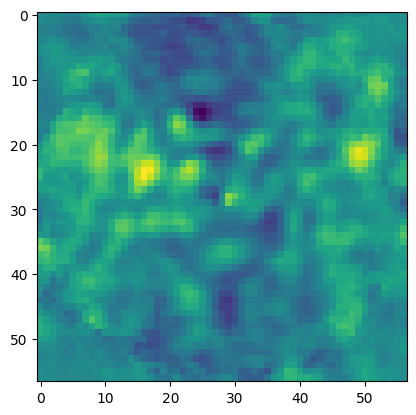

In [42]:
# New residual
plt.imshow(mean_residual_raw)

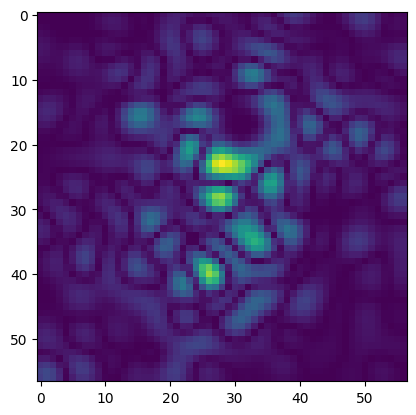

In [43]:
plt.imshow(s4_model_planet_npm.noise_model.betas[1000].view(57, 57).abs().detach())

plt.imshow(mean_residual_p_p)

# Models trained without the planet

In [ ]:
# Trained on raw with planet model
s4_model_raw_pm = S4(
    science_data=science_cut,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1289.89,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/gradient_descent",
    convolve=True,
    verbose=True)

s4_model_raw_pm.learn_planet_model(
    num_epochs=500,
    learning_rate_planet=1e-4,
    learning_rate_noise=1e-4,
    fine_tune_noise_model=True,
    rotation_grid_down_sample=1,
    upload_rotation_grid=True,
    logging_interval=10,
    batch_size=-1)

In [ ]:
# Trained on raw no planet model
s4_model_raw_npm = S4(
    science_data=science_cut,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1289.89,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/gradient_descent",
    convolve=True,
    verbose=True)

s4_model_raw_npm.fine_tune_noise_model(
    num_epochs=500,
    learning_rate=1e-4,
    batch_size=-1)

# Compute some residual

In [44]:
# Trained with planet Planet model
model = s4_model_planet_pm
model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
mean_residual_p_p = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

S4 model: computing residual ... [DONE]


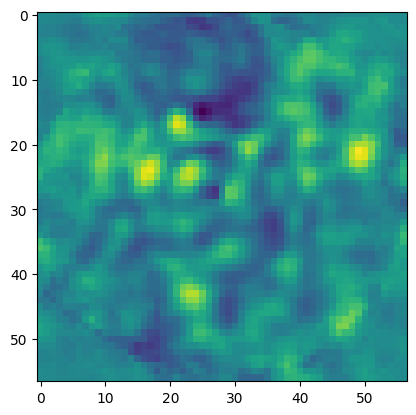

In [45]:
plt.imshow(mean_residual_p_p)

In [ ]:
# Trained with planet Planet model
model = s4_model_planet_pm
model.science_data = torch.from_numpy(science_cut).float()
mean_residual_p_p = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

# Trained with planet no Planet model
model = s4_model_planet_npm
model.science_data = torch.from_numpy(science_cut).float()
mean_residual_p_np = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

# Trained on raw Planet model
model = s4_model_raw_pm
model.science_data = torch.from_numpy(science_cut).float()
mean_residual_np_p = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

# Trained on raw np Planet model
model = s4_model_raw_npm
model.science_data = torch.from_numpy(science_cut).float()
mean_residual_np_np = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

In [ ]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))

ax1.imshow(mean_residual_p_p, origin="lower", vmin=-0.05, vmax=0.05)
ax2.imshow(mean_residual_p_np, origin="lower", vmin=-0.05, vmax=0.05)
ax3.imshow(mean_residual_p_p - mean_residual_np_p, origin="lower", vmin=-0.05, vmax=0.05)
ax4.imshow(mean_residual_p_np - mean_residual_np_np, origin="lower", vmin=-0.05, vmax=0.05)

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")
plt.tight_layout()

S4 model: computing residual ... [DONE]
S4 model: computing residual ... [DONE]


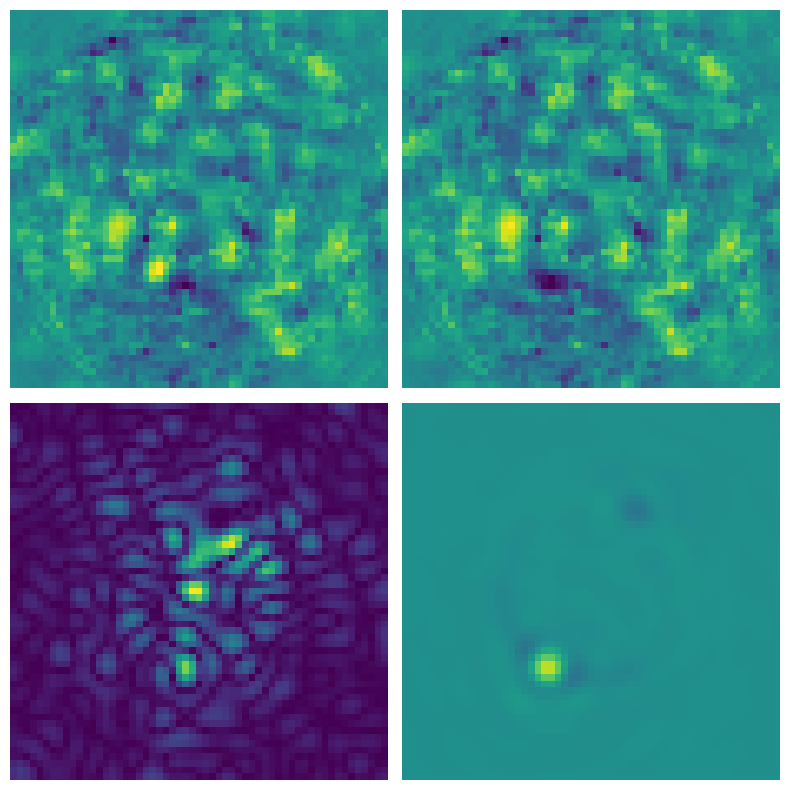

In [60]:
model = s4_model_gd

model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
mean_residual = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

model.science_data = torch.from_numpy(science_cut).float()
mean_residual_no_planet = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))

ax1.imshow(mean_residual, origin="lower", vmin=-0.05, vmax=0.05)
ax2.imshow(mean_residual_no_planet, origin="lower", vmin=-0.05, vmax=0.05)
ax4.imshow(mean_residual - mean_residual_no_planet, origin="lower", vmin=-0.1, vmax=0.1)
ax3.imshow(model.noise_model.betas[1000].view(57, 57).abs().detach())

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")
plt.tight_layout()

# The same but without the planet model

In [61]:
s4_model_gd2 = S4(
    science_data=data_with_fake_planet_cut,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_normalization="normal",
    noise_lambda_init=1289.89,
    planet_convolve_second=False,
    planet_use_up_sample=1,
    work_dir="/fast/mbonse/s4/70_results/08_train_jointly/01_0105c/gradient_descent",
    convolve=True,
    verbose=True)

In [62]:
s4_model_gd2.fine_tune_noise_model(
    num_epochs=2000,
    learning_rate=1e-4,
    batch_size=-1)

S4 model: fine tuning noise model ... 

  0%|          | 0/2000 [00:00<?, ?it/s]

[DONE]


S4 model: computing residual ... [DONE]
S4 model: computing residual ... [DONE]


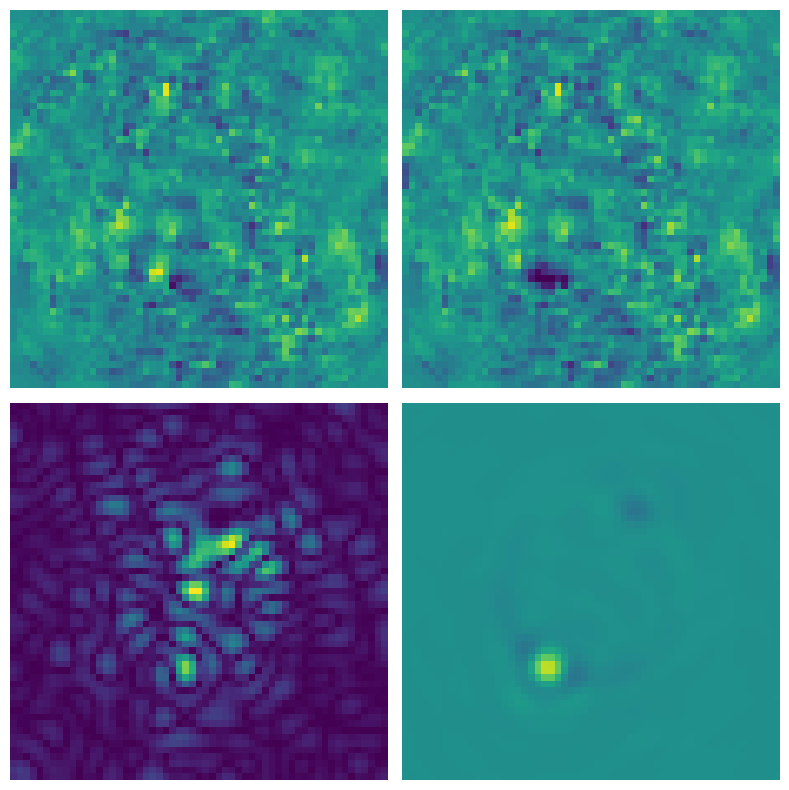

In [63]:
model = s4_model_gd2

model.science_data = torch.from_numpy(data_with_fake_planet_cut).float()
mean_residual = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

model.science_data = torch.from_numpy(science_cut).float()
mean_residual_no_planet = model.compute_residual(
    account_for_planet_model=False,
    combine="mean")

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(8,8))

ax1.imshow(mean_residual, origin="lower", vmin=-0.05, vmax=0.05)
ax2.imshow(mean_residual_no_planet, origin="lower", vmin=-0.05, vmax=0.05)
ax4.imshow(mean_residual - mean_residual_no_planet, origin="lower", vmin=-0.1, vmax=0.1)
ax3.imshow(model.noise_model.betas[1000].view(57, 57).abs().detach())

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")
plt.tight_layout()